# Train and Tune Linear Regression Model with MultioutputRegressor

In [1]:
from pathlib import Path

import optuna.visualization as vis
import pandas as pd

from config.config import Config
from src.models.factory import Experiment
from src.models.linreg import LinearElasticNet
from src.plots import plot_forecast_diagnostics, plot_forecast_next_h, plot_test_overlay_h1, prep_h1_overlay, \
    prep_h_overlay
from src.runners import run_experiments
from src.utils import set_seed

In [2]:
cfg = Config(Path("../config/config.yaml"))
SEED = cfg.runtime.seed
HORIZON = cfg.runtime.horizon
rng = set_seed(SEED)

2025-08-24 15:59:59,191 - INFO - src.utils - Global random seed set to 42


In [3]:
df_full = pd.read_csv(Path(cfg.data.processed_dir) / "features_full.csv")

In [4]:
experiments = [
    Experiment(
        name="linreg_wo_sent",
        build=lambda horizon, seed: LinearElasticNet(horizon=HORIZON, random_state=SEED, multioutput=True),
        include_sentiment=False
    )
]

In [5]:
results = run_experiments(df_full, Path(cfg.data.processed_dir), experiments, HORIZON, SEED)

2025-08-24 15:59:59,279 - INFO - ModelTrainer - Initialized ModelTrainer for model: linreg_wo_sent
[I 2025-08-24 15:59:59,280] A new study created in memory with name: no-name-a69fa260-e981-4d6b-8d97-fb66ef87d643
2025-08-24 15:59:59,280 - INFO - ModelTrainer - Starting model tuning...
[I 2025-08-24 15:59:59,365] Trial 0 finished with value: 0.009271378275791636 and parameters: {'alpha': 0.0001329291894316216, 'l1_ratio': 0.9507143064099162, 'max_iter': 3500, 'selection': 'cyclic'}. Best is trial 0 with value: 0.009271378275791636.
2025-08-24 15:59:59,365 - INFO - ModelTrainer - Starting model tuning...
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.064e+01, tolerance: 3.910e-02
  model = cd_fast.enet_coordinate_descent(
D:\IntelliJ\ml-stock-sent\.venv

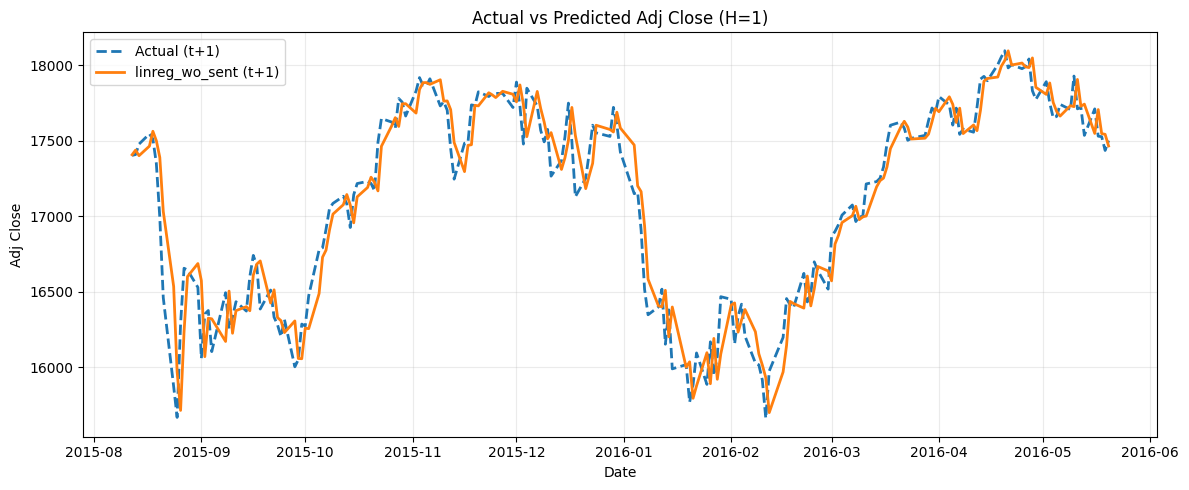

In [6]:
dates_next, actual_next, pred_next_by_model = prep_h1_overlay(df_full, results)
plot_test_overlay_h1(
    dates_next=dates_next,
    actual_next=actual_next,
    pred_next_by_model=pred_next_by_model,
    path=Path(cfg.data.fig_dir) / "linreg_wo_sent_actual_vs_predicted_adj_close.png",
)

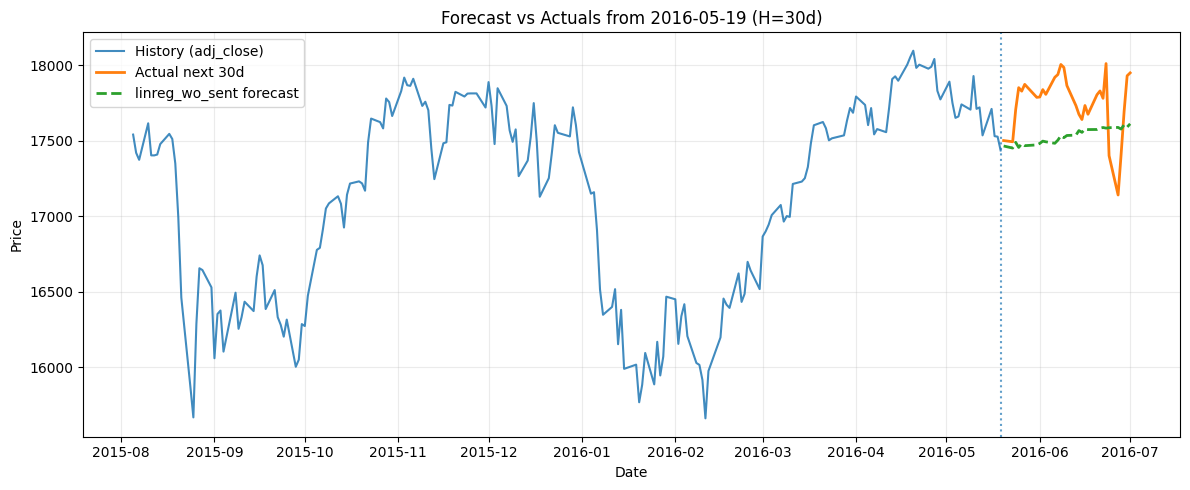

In [7]:
hist_dates, hist_prices, fut_dates, actual_path, anchor_date, paths_by_model = prep_h_overlay(df_full, results, HORIZON)
plot_forecast_next_h(
    hist_dates=hist_dates,
    hist_prices=hist_prices,
    fut_dates=fut_dates,
    forecast_paths_by_model=paths_by_model,
    actual_path=actual_path,
    anchor_date=anchor_date,
    H=HORIZON,
    path=Path(cfg.data.fig_dir) / "linreg_wo_sent_forecast.png",
)

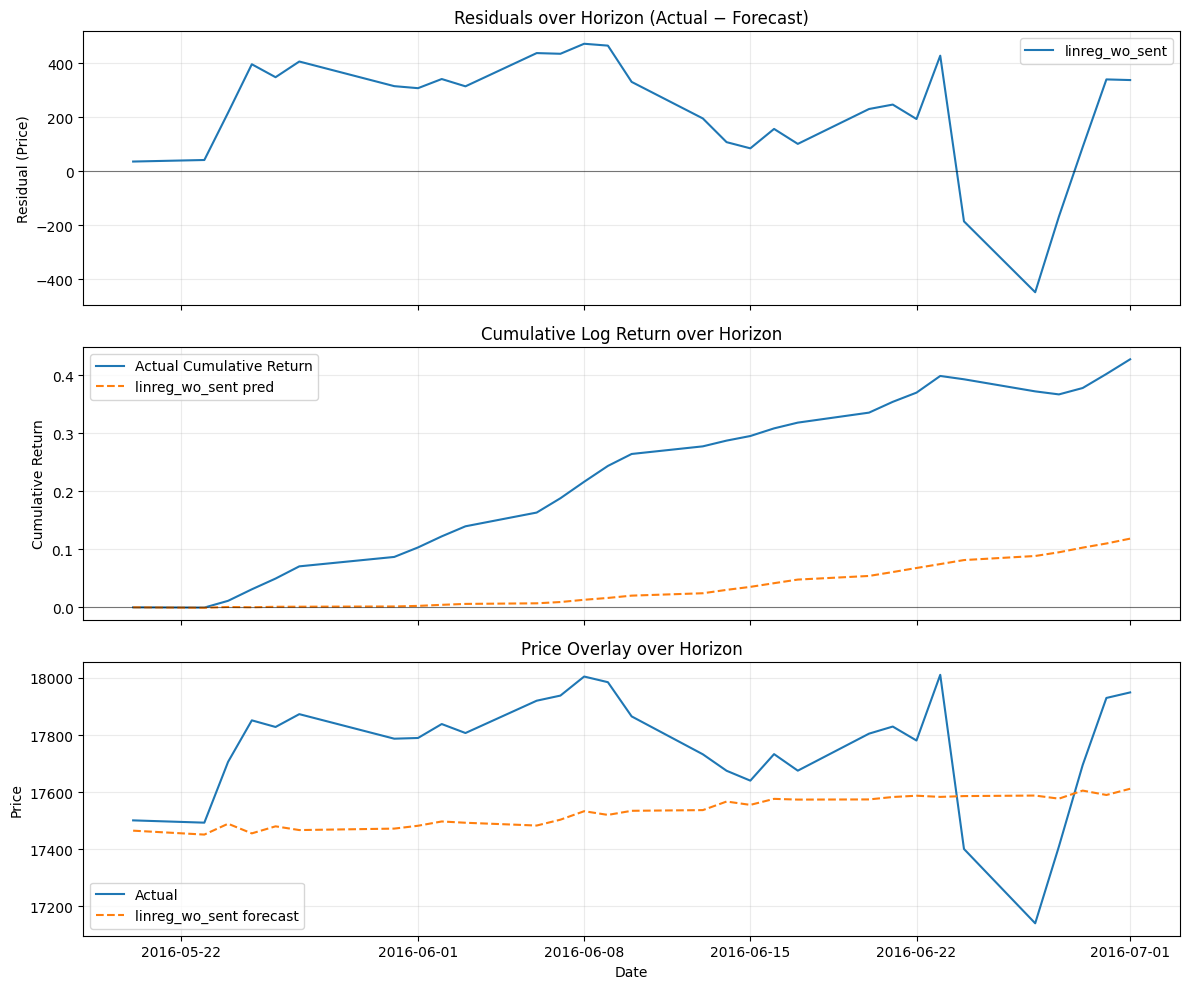

In [8]:
plot_forecast_diagnostics(
    fut_dates=fut_dates,
    actual_path=actual_path,
    forecast_paths_by_model=paths_by_model,
    path=Path(cfg.data.fig_dir) / "linreg_wo_sent_forecast_diagnostics.png",
)

In [9]:
pd.DataFrame(results[0]["best_params"], index=[0])

,alpha,l1_ratio,max_iter,selection,random_state
0,0.009311,0.839765,2000,random,42


In [10]:
pd.DataFrame(results[0]["metrics"]["test"], index=[0])

,mae,mse,rmse,smape,r2
0,0.00765,0.000102,0.010078,1.671144,-0.021612


In [11]:
study = results[0]["study"]

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_slice(study).show()
vis.plot_parallel_coordinate(study).show()
vis.plot_contour(study).show()
vis.plot_edf(study).show()

In [12]:
basedir = Path(cfg.data.processed_dir)

with_df = pd.read_csv(basedir / "metrics_test_linreg.csv")
wo_df = pd.read_csv(basedir / "metrics_test_linreg_wo_sent.csv")

with_df["sentiment"] = "with"
wo_df["sentiment"] = "without"

res = pd.concat([with_df, wo_df], ignore_index=True)

metric_cols = ["mae", "mse", "rmse", "smape", "r2"]
pivot = res.pivot(index="name", columns="sentiment", values=metric_cols).round(6)
display(pivot)

# optional: improvement table (positive => sentiment helps for errors; R2 reversed)
improve = pd.DataFrame(index=pivot.index)
for m in ["mae", "mse", "rmse", "smape"]:
    if (m, "with") in pivot.columns and (m, "without") in pivot.columns:
        improve[f"{m}_impr"] = pivot[(m, "without")] - pivot[(m, "with")]
if ("r2", "with") in pivot.columns and ("r2", "without") in pivot.columns:
    improve["r2_impr"] = pivot[("r2", "with")] - pivot[("r2", "without")]
display(improve.round(6))

mae                mse                rmse            \
sentiment           with  without      with   without      with   without   
name                                                                        
linreg          0.007701      NaN  0.000102       NaN  0.010108       NaN   
linreg_wo_sent       NaN  0.00765       NaN  0.000102       NaN  0.010078   

                   smape                  r2            
sentiment           with   without      with   without  
name                                                    
linreg          1.621985       NaN -0.027689       NaN  
linreg_wo_sent       NaN  1.671144       NaN -0.021612

,mae_impr,mse_impr,rmse_impr,smape_impr,r2_impr
name,,,,,
linreg,NaN,NaN,NaN,NaN,NaN
linreg_wo_sent,NaN,NaN,NaN,NaN,NaN
